# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats

In [1]:
def cost(X):
    cost = 0
    for elem in X:
        if elem == 1:
            cost += 100
        elif elem == 2:
            cost += 50
        elif elem == 3:
            cost += 40
        else:
            pass
    return cost

In [2]:
from olist.seller import Seller

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
initial2 = Seller().get_active_dates()

In [5]:
initial2.reset_index(inplace = True)

In [6]:
initial3 = Seller().get_sales()

In [7]:
initial3.reset_index(inplace = True)

In [8]:
initial4 = initial3.merge(initial2, on = 'seller_id', how = 'inner')

In [9]:
initial4.drop(columns = ['date_first_sale', 'date_last_sale'], inplace = True)

In [10]:
initial4

,seller_id,sales,months_on_olist
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,1.0
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03,17.0
2,001e6ad469a905060d959994f1b41e4f,250.00,0.0
3,002100f778ceb8431b7a1020ff7ab48f,1234.50,7.0
4,003554e2dce176b5555353e4f3555ac8,120.00,0.0
...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,69.90,0.0
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,2101.20,18.0
3092,ffeee66ac5d5a62fe688b9d26f83f534,1839.86,7.0
3093,fffd5413c0700ac820c7069d66d98c89,9062.30,13.0


In [11]:
from olist.data import Olist

In [12]:
raw2 = Olist().get_data()['order_items']

In [13]:
raw = Olist().get_data()

In [14]:
raw = raw['order_reviews']

In [15]:
columns =['review_id', 'order_id', 'review_raw', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp']

In [16]:
raw.columns = columns

In [17]:
raw = raw.merge(raw2, on = 'order_id', how = 'inner')

In [18]:
merged = initial4.merge(raw, on = 'seller_id', how = 'inner')

In [19]:
merged.head()

,seller_id,sales,months_on_olist,review_id,order_id,review_raw,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,shipping_limit_date,price,freight_value
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,1.0,799c3e3362ac0d09cfa1b39b51647490,9dc8d1a6f16f1b89874c29c9d8d30447,5,NaN,NaN,2017-10-25 00:00:00,2017-10-25 23:15:15,1,a2ff5a97bf95719e38ea2e3b4105bce8,2017-10-18 14:49:22,895.0,21.02
1,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,1.0,2abb25fde5aafe9bc85d031dffb2f4ac,7f39ba4c9052be115350065d07583cac,1,NaN,"Produto preto, reembalado na caixa de um branc...",2017-10-28 00:00:00,2017-10-28 14:32:42,1,a2ff5a97bf95719e38ea2e3b4105bce8,2017-10-24 23:56:20,895.0,21.02
2,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,1.0,f6923b4d17e0f4e87b38cb26c758d3c6,d455a8cb295653b55abda06d434ab492,5,NaN,NaN,2017-10-08 00:00:00,2017-10-11 21:42:45,1,a2ff5a97bf95719e38ea2e3b4105bce8,2017-10-12 22:24:16,895.0,21.02
3,001cca7ae9ae17fb1caed9dfb1094831,25080.03,17.0,294ac04cc8ee1d2073999678cb401c88,ef208a54d9b685d3a803b28bcfd72f3a,5,NaN,NaN,2017-05-10 00:00:00,2017-05-11 14:47:50,1,547b95702aec86f05ac37e61d164891c,2017-05-09 11:33:53,99.5,42.98
4,001cca7ae9ae17fb1caed9dfb1094831,25080.03,17.0,22d673c480b6f057c92dfb2f0fb2b9fe,128db96d96f727da26afde4579e68d48,4,NaN,"Lavabo bem bonito e igual a descrição, veio co...",2017-07-20 00:00:00,2017-07-23 01:22:00,1,08574b074924071f4e201e151b152b4e,2017-07-14 16:55:16,89.0,41.01


In [20]:
final = merged.groupby('seller_id').agg({'review_raw': [cost, 'count'], 'sales' : 'first', 'months_on_olist': 'first'})

In [21]:
final.reset_index(inplace = True)

In [22]:
final

seller_id review_raw           sales  \
                                             cost count     first   
0     0015a82c2db000af6aaaf3ae2ecb0532        100     3   2685.00   
1     001cca7ae9ae17fb1caed9dfb1094831       4750   236  25080.03   
2     001e6ad469a905060d959994f1b41e4f        100     1    250.00   
3     002100f778ceb8431b7a1020ff7ab48f       1110    56   1234.50   
4     003554e2dce176b5555353e4f3555ac8          0     1    120.00   
...                                ...        ...   ...       ...   
3085  ffcfefa19b08742c5d315f2791395ee5        100     1     69.90   
3086  ffdd9f82b9a447f6f8d4b91554cc7dd3        240    20   2101.20   
3087  ffeee66ac5d5a62fe688b9d26f83f534        200    14   1839.86   
3088  fffd5413c0700ac820c7069d66d98c89       1360    60   9062.30   
3089  ffff564a4f9085cd26170f4732393726       1420    20   1426.30   

     months_on_olist  
               first  
0                1.0  
1               17.0  
2                0.0  
3                7.0  
4                0.0  
...              ...  
3085             0.0  
3086            18.0  
3087             7.0  
3088            13.0  
3089             6.0  

[3090 rows x 5 columns]

In [23]:
columns2 = ['seller_id','cost_of_reviews', 'count_of_reviews', 'sales_total', 'months_on_olist']

In [24]:
final.columns = columns2

In [25]:
final['revenues'] = (final['sales_total'] * 0.1) + (final['months_on_olist'] * 80)

In [26]:
final['profits'] = final['revenues'] - final['cost_of_reviews']

In [27]:
returner = final[['seller_id', 'revenues', 'cost_of_reviews', 'profits']]

In [28]:
columns3 = ['seller_id', 'revenues', 'review_costs', 'profits']

In [29]:
returner.columns = columns3

In [30]:
returner

,seller_id,revenues,review_costs,profits
0,0015a82c2db000af6aaaf3ae2ecb0532,348.500,100,248.500
1,001cca7ae9ae17fb1caed9dfb1094831,3868.003,4750,-881.997
2,001e6ad469a905060d959994f1b41e4f,25.000,100,-75.000
3,002100f778ceb8431b7a1020ff7ab48f,683.450,1110,-426.550
4,003554e2dce176b5555353e4f3555ac8,12.000,0,12.000
...,...,...,...,...
3085,ffcfefa19b08742c5d315f2791395ee5,6.990,100,-93.010
3086,ffdd9f82b9a447f6f8d4b91554cc7dd3,1650.120,240,1410.120
3087,ffeee66ac5d5a62fe688b9d26f83f534,743.986,200,543.986
3088,fffd5413c0700ac820c7069d66d98c89,1946.230,1360,586.230


In [1]:
from olist.seller import Seller

In [2]:
ex = Seller()

In [39]:
max(ex.get_training_data()['review_costs'])

44620

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the items they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

In [1]:
from olist.seller import Seller

In [2]:
l = Seller().get_training_data()

In [25]:
l

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,revenues,review_costs,profits,share_of_one_stars,share_of_five_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000000,218.70,341.870,140,201.870,0.333333,0.333333,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025000,11703.07,2290.307,240,2050.307,0.050000,0.725000,4.55
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000000,158.00,15.800,0,15.800,0.000000,1.000000,5.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000000,79.99,7.999,0,7.999,0.000000,1.000000,5.00
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000000,167.99,16.799,100,-83.201,1.000000,0.000000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,2,2,1.000000,158.00,15.800,0,15.800,0.000000,1.000000,5.00
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,10,10,1.000000,889.00,1208.900,140,1068.900,0.100000,0.500000,4.10
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,6,7,1.166667,550.04,455.004,0,455.004,0.000000,1.000000,5.00
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,8,11,1.375000,297.00,349.700,50,299.700,0.000000,0.500000,4.25


In [33]:
min(l['profits'])

-26349.517

In [4]:
max(l['revenues'])

24387.263000000003

In [5]:
import numpy as np

In [6]:
def it_costs(X):
    n_sellers = len(X)
    n_items = sum(X['quantity'])
    a = 3157.27
    b = 978.23
    final = (a * np.sqrt(n_sellers)) + (b * np.sqrt(n_items))
    return final

In [7]:
it_costs(l)

499999.31851932954

In [8]:
def total_profits(X):
    total_rev = sum(X['profits'])
    total_costs = it_costs(X)
    return total_rev - total_costs

In [9]:
total_profits(l)

309169.12548067013

In [10]:
sum(l['profits'])

809168.4439999997

In [26]:
len(l)

2967

In [11]:
 k = l.drop(l[l['profits'] < 0].index)

In [30]:
len(l) - len(k)

492

In [24]:
tess = k.copy()
tess.reset_index(inplace = True)
tess = tess.sort_values(by = 'profits')
tess.reset_index(inplace = True)
t = tess.copy()
profits = []
lent = []
for i in range(len(t)):
    t.drop([i], inplace = True)
    lent.append(len(t))
    to = total_profits(t)
    profits.append(to)
    

In [20]:
import matplotlib.pyplot as plt

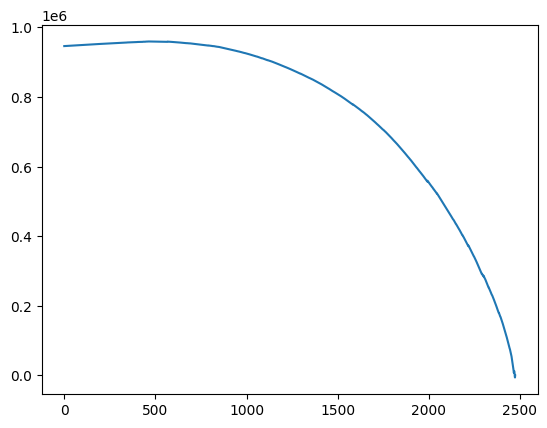

In [21]:
plt.plot(profits)

In [122]:
profits.index(max(profits))

462

In [31]:
max(profits)

959257.3029502246

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


### 1

Analysing bad products. Criteria are a mean review of less than 3 and over 5 reviews

In [35]:
from olist.seller import Seller

In [37]:
from olist.data import Olist

In [97]:
items = Olist().get_data()['order_items']

In [98]:
from olist.seller import Seller

In [99]:
from olist.data import Olist

In [100]:
items = Olist().get_data()['order_items']

In [101]:
reviews = Olist().get_data()['order_reviews']

In [102]:
merged = items.merge(reviews, on = 'order_id', how = 'inner')

In [103]:
product_sorted = merged.groupby('product_id').agg({'review_score': ['mean', 'count'], 'seller_id': 'first'})

In [104]:
columns = ['product_id', 'mean_review', 'n_reviews', 'seller_id']

In [105]:
product_sorted.reset_index(inplace = True)

In [106]:
product_sorted.columns = columns

In [107]:
product_sorted = product_sorted.sort_values(by = 'mean_review')

In [108]:
product_sorted = product_sorted[product_sorted['n_reviews'] > 5]

In [109]:
bad_reviews = product_sorted[product_sorted['mean_review'] < 3]

In [110]:
bad_reviews

,product_id,mean_review,n_reviews,seller_id
21537,a8fd2715c837d04bac16cf90155919f8,1.000000,6,8d899e15a5925f097cca50faa49b15e3
21921,ac1ad58efc1ebf66bfadc09f29bdedc0,1.000000,6,98dac6635aee4995d501a3972e047414
19485,986700c98805af229ab7ad51b95fa356,1.000000,7,a0e19590a0923cdd0614ea9427713ced
7432,399f54c06661d06ca45c6e24ed238e0e,1.000000,6,d2374cbcbb3ca4ab1086534108cc3ab7
1838,0e1fa2aadc04afbf8fb30200aeba06a2,1.000000,10,7a241947449cc45dbfda4f9d0798d9d0
...,...,...,...,...
28276,dc68ee0fcb033a1ab6714fbb5db60c15,2.928571,14,02d35243ea2e497335cd0f076b45675d
19803,9ad75bd7267e5c724cb42c71ac56ca72,2.931818,44,8160255418d5aaa7dbdc9f4c64ebda44
22982,b40ec43bdfc6d6fdd65e882066a5c895,2.933333,15,897060da8b9a21f655304d50fd935913
10578,51f876eb62be778c757503cf7f8a3b74,2.937500,32,f84a00e60c73a49e7e851c9bdca3a5bb


In [111]:
list_bad_product = list(bad_reviews['product_id'])

### 2

 Analyzing bad products with statistical test (t-test) with 90% confidence interval. 90% likelihood for the population of a given product to have a mean review score of less than 3 based on the sample of reviews we have for a given product

In [59]:
product_sorted = merged.groupby('product_id').agg({'review_score': ['mean', 'count', 'std'], 'seller_id': 'first'})

In [61]:
columns = ['product_id', 'mean_review', 'n_reviews', 'std','seller_id']

In [62]:
product_sorted.reset_index(inplace = True)

In [63]:
product_sorted.columns = columns

In [64]:
def calculate_p_value(row):
    if row['n_reviews'] == 1:
        return 1 
    elif row['std'] == 0:
        return 1 
    else:
        t_statistic = (row['mean_review'] - 3) / (row['std'] / np.sqrt(row['n_reviews']))
        dff = row['n_reviews'] - 1
        p_value = stats.t.cdf(t_statistic, dff)
        return p_value

In [67]:
product_sorted['p_value'] = product_sorted.apply(calculate_p_value, axis=1)

In [69]:
bad_reviews = product_sorted[product_sorted['p_value'] < 0.1]

In [70]:
list_bad_product = list(bad_reviews['product_id'])

## filtering out bad products

In [112]:
initial2 = Seller().get_active_dates()

In [113]:
initial2.reset_index(inplace = True)

In [114]:
initial3 = Seller().get_sales()

In [115]:
initial3.reset_index(inplace = True)

In [116]:
initial4 = initial3.merge(initial2, on = 'seller_id', how = 'inner')

In [117]:
initial4.drop(columns = ['date_first_sale', 'date_last_sale'], inplace = True)

In [118]:
raw2 = Olist().get_data()['order_items']

In [119]:
raw = Olist().get_data()

In [120]:
raw = raw['order_reviews']

In [121]:
filtered = raw2.drop(raw2[raw2['product_id'].isin(list_bad_product) == True].index)

In [122]:
filtered_merged = filtered.merge(raw, on = 'order_id', how = 'left')

In [123]:
alll = filtered_merged.merge(Seller().get_sales(), on = 'seller_id').merge(Seller().get_active_dates(), on = 'seller_id')

In [124]:
fina = alll.merge(Seller().get_financials(), on = 'seller_id')

In [125]:
def cost(X):
            cost = 0
            for elem in X:
                if elem == 1:
                    cost += 100
                elif elem == 2:
                    cost += 50
                elif elem == 3:
                    cost += 40
                else:
                    pass
            return cost

In [126]:
han = fina.groupby('seller_id').agg({'review_score': [cost, 'mean'], 'sales' : 'first', 'months_on_olist': 'first'})

In [127]:
han.reset_index(inplace = True)

In [128]:
columns2 = ['seller_id','cost_of_reviews', 'count_of_reviews', 'sales_total', 'months_on_olist']

In [129]:
han.columns = columns2

In [130]:
han['revenues'] = (han['sales_total'] * 0.1) + (han['months_on_olist'] * 80)
han['profits'] = han['revenues'] - han['cost_of_reviews']
returner = han[['seller_id', 'revenues', 'cost_of_reviews', 'profits']]
columns3 = ['seller_id', 'revenues', 'review_costs', 'profits']
returner.columns = columns3

In [131]:
qu = returner.merge(Seller().get_quantity()[['seller_id', 'quantity']], on = 'seller_id')

In [132]:
k = qu.drop(qu[qu['profits'] < 0].index)

In [133]:
total_profits(k)

993731.5560426107

In [134]:
tess = k.copy()
tess.reset_index(inplace = True)
tess = tess.sort_values(by = 'profits')
tess.reset_index(inplace = True)
t = tess.copy()
profits = []
lent = []
for i in range(len(t)):
    t.drop([i], inplace = True)
    lent.append(len(t))
    to = total_profits(t)
    profits.append(to)

In [135]:
max(profits)

1006540.2106700407

In [136]:
profits.index(max(profits))

472

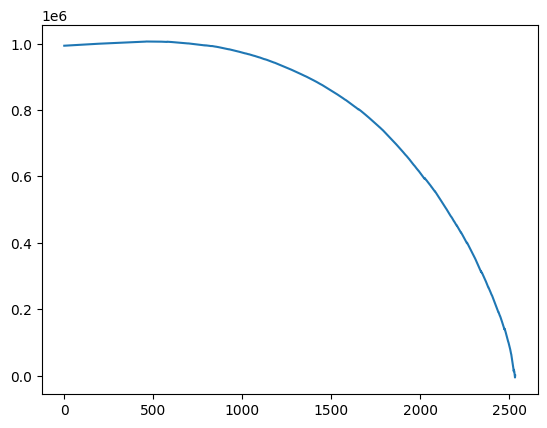

In [137]:
plt.plot(profits)

## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪